In this Notebook we will implement a basic version of Gaussian Processes.

For this, recall a Gaussian Process is a Stochastic process, where each (finite) subset of Datapoints $D = \{x_i\}_i$ is distributed to some Normal (Gaussian ) distribution: $D \sim N(\mu_u, \Sigma_i)$, where $\mu$ and $\Sigma$ are the mean and (co-)variance respectively.

Implementing a Gaussian Process is more a mathematical than an Computational Problem, making it efficient is however not that straightforward. In the following we make no claim of computational optimality, so if you intend to use Gaussian Processes in your application, be advised to use one of the many fantastic, already existing Packages.

We will approximate the following function:

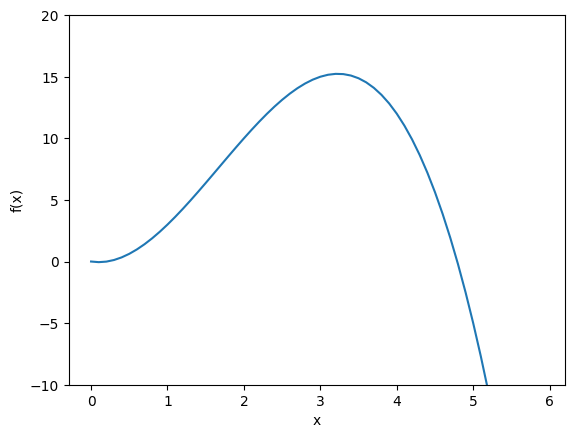

In [221]:
def f(x):
    return -x**3 + 5*x**2 -x 

import matplotlib.pyplot as plt
xx = jnp.arange(0., 6, 0.1)
yy = [f(x) for x in xx]
fig = plt.figure()
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10,20);
plt.show()

In this project we will be using JAX.

In [1]:
import jax
import jax.numpy as jnp


The biggest task in using Gaussian Processes is using an appropriate Kernel Function.
In the following, we implement some for later use:

    - RBF kernel (Eucilidic distance)
    - ARD kernel (Mahalanobis distance)
    -

In [22]:
@jax.jit
def rbf_kernel(x, y, l=0.1):
    return jnp.exp(-jnp.divide(jnp.vdot(x-y,x-y), 2*jnp.power(l,2)))

@jax.jit
def ARD_kernel(x,y, sigma_inv ,l=0.1):
    return jnp.exp(
        -jnp.divide(
        jnp.vdot((x-y), sigma_inv @ (x-y)) ,  2*jnp.power(l,2)
        )
    )

For Inference, we will need to calculate the conditionial expectation $\mu$ and the conditional variance $\Sigma$:

In [165]:
def Gram_XX(D, kernel):
    #Calculates the Gram matrix of the Data
    return jnp.array([kernel(x,y) for x in D for y in D]).reshape(len(D),len(D))
    
def K_TXstar(x,D, kernel):
    s = jax.vmap(kernel,(None, 0))
    return s(x, D)

def K_xx(G):
    return jnp.linalg.inv(G)

def Sigma_starstar(x, kernel, K_Txstar, K_xx):
    return kernel(x,x) - K_Txstar @ K_xx @ K_Txstar

def mu_star_D(mu_star, ktx, kxx, fx, mu_x):
    return mu_star + ktx @ kxx @ (fx - mu_x)


In [222]:
D = jnp.array([1,2,3,4,5])
fd = jnp.array([f(x) for x in D])

In [214]:
kernel = lambda x,y : rbf_kernel(x,y, l=0.5)
g = Gram_XX(D, kernel)
kxx = K_xx(g)

def prediction(x):
    ktx = K_TXstar(x, D, kernel)
    std = Sigma_starstar(x, kernel, ktx, kxx)
    msd = mu_star_D(0.0, ktx=ktx, kxx=kxx, fx=fd, mu_x=jnp.zeros(len(D)))
    return msd, std

In [215]:
preds = jax.vmap(prediction, 0)
ys, stds = preds(xx)

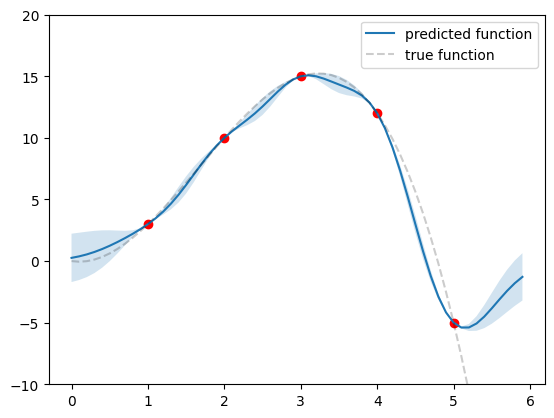

In [216]:
plt.plot(xx, ys, label='predicted function')
plt.plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
plt.fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
plt.scatter(D, fd, color='red')
plt.ylim(-10,20)
plt.legend()

We can use this approximation as a surrogate model used in active learning:
Here, the goal is to approximate $f(x)$ to the best of our possibilities, while keeping the needed function evaluations to a minimum; one (propably not optimal, but acceccisble) approach is to queuery for the points with lowest confidence = largest variance.

With the example from above, we can:

    1.) select a point of mixumum merit
    2.) compute f(x)
    3.) condition the GP on (x, f(x))
    4.) repeat until profit

In [224]:
#SETTINGS FOR THE PROBLEM
lower_domain_limit = 0
upper_domain_limit = 6


1.) choose a random point. Due to implementation limitations, we do not actually draw from the gaussian process; however since it is not conditioned on anything, we can just draw according to our prior (which we assume as $\mathcal{N}(0,1)$, and hence $x_1 \sim$ Uni $(D)$ with D the domain of intrest).


In [ ]:
key = jax.random.PRNGKey(0)
x_0 = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)

2.) In this example, we can just call the python function $f(x)$; however in general this may be arbitrary complex, e.g. running a COMSOL simulation, train a ML model or whatever we want.

In [226]:
y_0 = f(x_0)

3.) Now we need to condition on (x, f(x)), that is calculate $m_{\star | X}$ and $\Sigma_{\star | X}$. We will calculate most of it during the prediction call; however it is smart to precalculate the expensive (and constant parts) of the expression:

In [261]:
D = jnp.array(x_0)
fd = jnp.array(y_0)
kernel = lambda x,y : rbf_kernel(x,y, l=0.5)
g = Gram_XX(D, kernel)
kxx = K_xx(g)

We then can make a prediction:

In [230]:
def prediction(x):
    ktx = K_TXstar(x, D, kernel)
    std = Sigma_starstar(x, kernel, ktx, kxx)
    msd = mu_star_D(0.0, ktx=ktx, kxx=kxx, fx=fd, mu_x=jnp.zeros(len(D)))
    return msd, std

4.) / 1.)
Now we need to select the newest point: For this, find the point with the most merit:
We can do this on the whole domain, as now the evaluation of the GP is (comperatively) cheap!
(In this example, the most merit is just the most reduction of variance, )

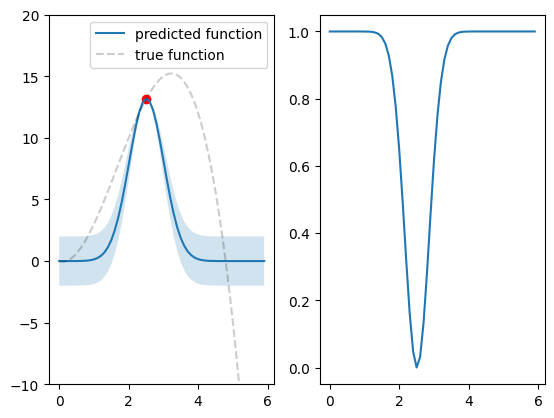

In [247]:
preds = jax.vmap(prediction, 0)
xx = jnp.arange(0., 6, 0.1)
ys, stds = preds(xx)
ys = ys.reshape(-1) #flatten ys
fig, axes  = plt.subplots(1,2)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].legend()
axes[1].plot(xx, stds, label='Variance')


In [248]:
def obtain_predictor(D,fd, kernel):
    g = Gram_XX(D, kernel)
    kxx = K_xx(g)
    
    def prediction(x):
        ktx = K_TXstar(x, D, kernel)
        std = Sigma_starstar(x, kernel, ktx, kxx)
        msd = mu_star_D(0.0, ktx=ktx, kxx=kxx, fx=fd, mu_x=jnp.zeros(len(D)))
        return msd, std

    return jax.vmap(prediction, 0)
    

In [342]:
@jax.jit
def exp_unc(x_prop):
    D_prop = jnp.append(D, x_prop)
    fd_prop = jnp.append(fd, 1000)
    predictor = obtain_predictor(D_prop, fd_prop, kernel)
    #"Integrate over the uncertainty"
    _, stds = predictor(xx)
    binsize = (xx.max() - xx.min()) / xx.shape[0]
    return sum(stds)#binsize

The expected integrated uncertainty serves as a loss function.
We want the newest point to be the one which minimizes it, while being within our Domain.
NOTE: it is differentiable! Hence we could do an optimization like this:

In [345]:
exp_unc(jnp.array(0.0))

Array(46.21034, dtype=float32)

In [351]:
#Quasi newton with guessed hessian. (Gradient descent!)
def gradient_descend(x_0, domain_limits, epsilon = 1e-5, maxiter = 1000):
    x = x_0
    lower_domain_limit, upper_domain_limit = domain_limits
    #run for as long as we can
    for iter in range(maxiter):
        grad = jax.grad(exp_unc)(x)
        #early stopping conditions
        if grad < epsilon:
            break

        #outside of domain: bring back into domain and end iteration
        if x < lower_domain_limit:
            x = lower_domain_limit
            break

        if x > upper_domain_limit:
            x = upper_domain_limit
            break   
        
        x = x - 0.1*grad
    return x, grad

In [355]:
x_proposed, _ = gradient_descend(jnp.array(1.5), (lower_domain_limit, upper_domain_limit), maxiter=1000)

The proposed point $x_{\text{proposed}}$ is now a point of maximum Merit! (in the sense that we found it with gradient descent and merit means less total variance if we condition on it...)
In this simple example, it is feasible to just iterate through a fine grid, e.g. xx (which we use to evaluate the loss anyways...)

In [356]:
losses = jax.vmap(exp_unc, 0)(xx)

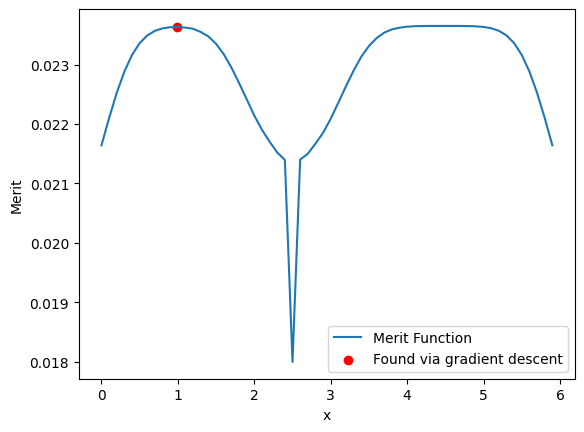

In [365]:
plt.plot(xx, 1/losses, label="Merit Function")
plt.ylabel("Merit")
plt.xlabel("x")
plt.scatter(x_proposed, 1/exp_unc(x_proposed), color='red', label="Found via gradient descent")
plt.legend()


But how good is our guess?

In [367]:
1/exp_unc(x_proposed) - max(1/losses)

Array(-1.7415732e-05, dtype=float32)

We see that our found proposed point is not quite the best, but it is still very good (and locally the best).
For finding the true best new point to condition on, all we have to do is to solve the global optimization propblem (and solve non convex optimization).

For now, let us add the condition on $x_{\text{proposed}}$ and call it a day.

In [396]:
D = jnp.append(D, x_proposed)
#calculate the new f(x_proposed) aswell!
fd = jnp.append(fd, f(x_proposed))
#obtain new predictor
predictor = obtain_predictor(D, fd, kernel)
#obtain new predictions
xx = jnp.arange(0., 6, 0.1)
ys, stds =  predictor(xx)

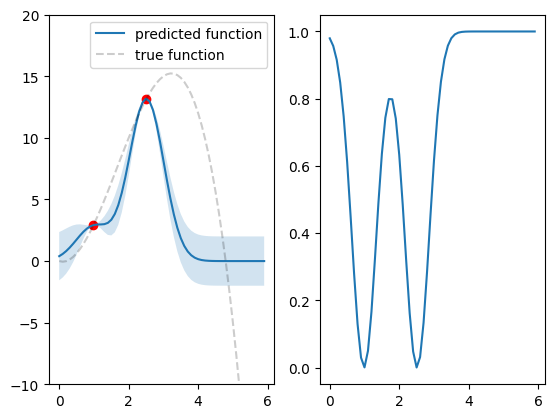

In [398]:
 #flatten ys
fig, axes  = plt.subplots(1,2)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].legend()
axes[1].plot(xx, stds, label='Variance')

In [397]:
ys

Array([3.9873141e-01, 5.8001566e-01, 8.1070143e-01, 1.0888613e+00,
       1.4054868e+00, 1.7438897e+00, 2.0807743e+00, 2.3892691e+00,
       2.6437602e+00, 2.8258202e+00, 2.9301150e+00, 2.9689887e+00,
       2.9745133e+00, 2.9971867e+00, 3.1009250e+00, 3.3545761e+00,
       3.8206949e+00, 4.5429120e+00, 5.5337591e+00, 6.7653546e+00,
       8.1654863e+00, 9.6212626e+00, 1.0991227e+01, 1.2124973e+01,
       1.2886987e+01, 1.3179880e+01, 1.2961659e+01, 1.2252776e+01,
       1.1131244e+01, 9.7171564e+00, 8.1506948e+00, 6.5689406e+00,
       5.0866733e+00, 3.7844756e+00, 2.7052546e+00, 1.8579788e+00,
       1.2260321e+00, 7.7730632e-01, 4.7349027e-01, 2.7711347e-01,
       1.5582353e-01, 8.4185392e-02, 4.3698594e-02, 2.1793535e-02,
       1.0442780e-02, 4.8076492e-03, 2.1265605e-03, 9.0375193e-04,
       3.6902068e-04, 1.4477060e-04, 5.4568023e-05, 1.9761701e-05,
       6.8760110e-06, 2.2986837e-06, 7.3832848e-07, 2.2785002e-07,
       6.7557934e-08, 1.9245492e-08, 5.2676006e-09, 1.3852407e

In [375]:
ys.shape

(60,)